In [1]:
import matplotlib.pyplot as plt
import numpy as np
from brian2.only import *
import seaborn as sns
import deepdish as dd
from scipy.stats import bootstrap

import plot_utils as pu
from digest import conds, get_digest_output, get_voltages
import isi_indexing as ii
from readout import load_results
from digest import get_voltage_histograms

import conf.isi5_mouse as cfg

In [2]:
labelling = {
    'pspike': 'Spike probability',
    'Activity': '$V_{static}$ (mV)',
    'Depression': '$V_{STD}$ (mV)',
    'Threshold': '$V_{TA}$ (mV)',
    'Synapses': '$V_{syn}$ (mV)',
    'Reset': '$V_{reset}$ (mV)',
    'v': 'Membrane potential v (mV)',
    'u': 'Undepressed potential u (mV)',
    'th_adapt': 'Threshold (mV)',
    'vsyn': '$v_{syn}$',
    'Vall': '$\\Sigma V$ (mV)'
}
depressive_measures = ('Depression', 'Threshold')
voltage_measures = depressive_measures + ('Synapses', 'Reset')
raw_measures = 'th_adapt', 'u', 'v', 'vsyn'
pu.colors.update({'Activity': 'cyan', 'Vall': 'k',
                  'th_adapt': pu.colors['Threshold'], 'u': pu.colors['Depression'], 'v': 'b', 'vsyn':'magenta'})
conds = ('std', 'msc', 'dev')
nonstandard = ('msc', 'dev')

In [3]:
net, isi, STD, TA, templ = 7, 500, 1, 1, 0
ipair, istim = 0, 1
pair, stim = cfg.pairings[ipair], cfg.pairings[ipair][istim]
fname_format = dict(net=net, isi=isi, STD=STD, TA=TA, templ=templ)
res = load_results(cfg.fname.format(**fname_format), {'u': 'v'}, raw_fbase=cfg.raw_fbase.format(**fname_format))
res['voltage_histograms'] = get_voltage_histograms(cfg.params, res)

In [4]:
quarters = [.25, .5, .75]

In [5]:
histograms = {cond: {
    'pspike': res['spikes'][ipair][stim][cond]['spike_hist'],
    **{measure: res['voltage_histograms'][measure][ipair][stim][cond] for measure in voltage_measures}
} for cond in conds}

In [6]:
nspikes = {cond: res['spikes'][ipair][stim][cond]['nspikes'] for cond in conds}

In [7]:
raw_voltages = {cond: {
    **get_voltages(cfg.params, {k:v*volt for k,v in res['dynamics'][ipair][stim][cond].items()}),
    **{k:v*volt for k,v in res['dynamics'][ipair][stim][cond].items()},
} for cond in conds}
for v in raw_voltages.values():
    v['Vall'] = cfg.params['v_rest'] - cfg.params['v_threshold'] + v['Synapses'] + v['Reset'] - v['Depression'] - v['Threshold']
    assert np.allclose(v['Vall']/mV, (v['v'] - (cfg.params['v_threshold']+v['th_adapt']))/mV)

In [8]:
index_N, index_t = ii.get_onset_ordering(cfg, np.stack([h['pspike'] for h in histograms.values()]))
tmax = np.max(index_t)+1
time = np.arange(tmax) * cfg.params['dt']

In [9]:
def plot_hists(hists, index_N, index_t, title=None, width=5, height=10, labelling=labelling, **kwargs):
    labels = None
    for measure, hist in hists.items():
        if labels is None:
            labels, descriptor = ii.getlabels(cfg, cfg.N_templates, True, **kwargs)
        hist = hists[measure]
        if measure in voltage_measures:
            hist = hist/mV
        fig, axs, cb = pu.plot_pulse_hist(
            hist, index_N, index_t, cfg.params['dt'],
            figsize=(width*len(hist), height), symmetric=False, cmap='turbo')
        for ax in axs:
            ax.set_title(labelling[measure])
        fig.suptitle('\n'.join(filter(None, [measure, descriptor])) if title is None else title)
        cb.set_label(labelling[measure])
    plt.show()
    plt.close('all')

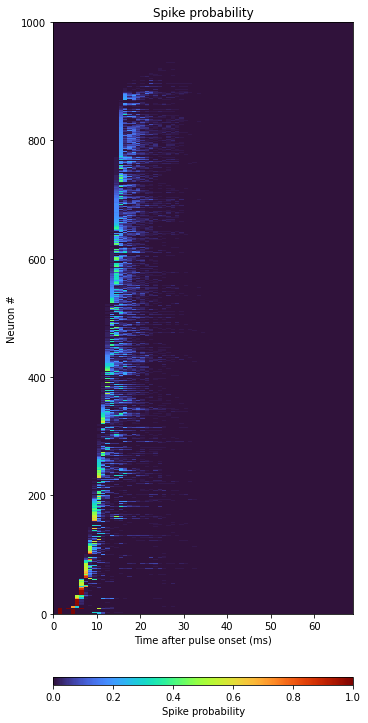

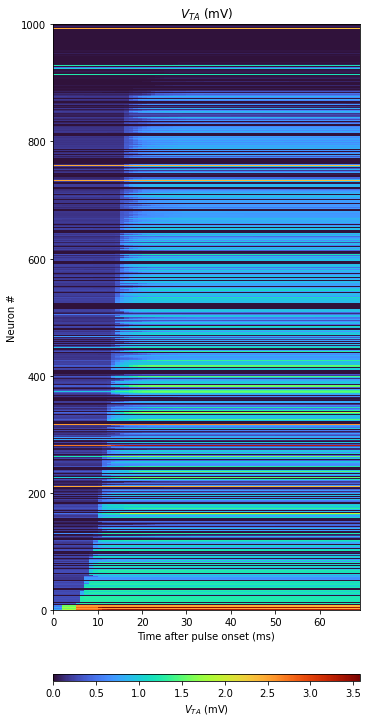

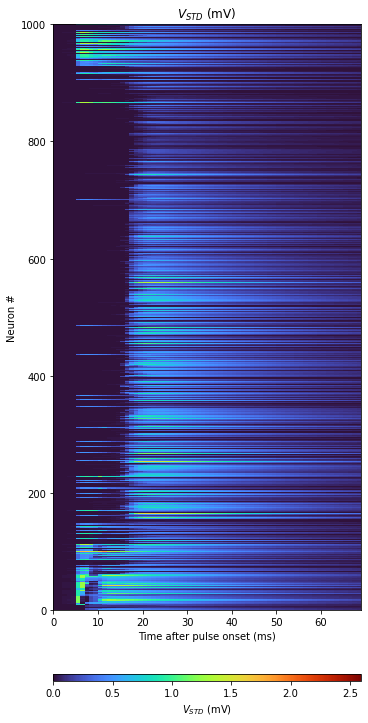

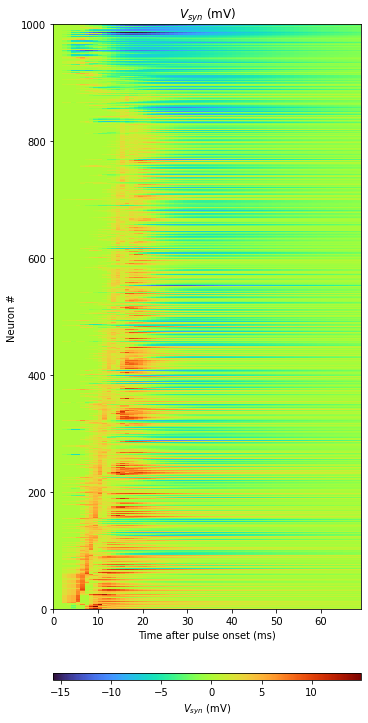

In [10]:
plot_hists({k:histograms['dev'][k][None,:,:] for k in ('pspike', 'Threshold', 'Depression', 'Synapses')}, index_N, index_t, title='', ipair=ipair, istim=istim)